# Demand ML
Having preparing our dataset in 'ml_dataprep.ipynb', we will now do random forest to predict demand

In [1]:
import geopandas as gpd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df_trips = pd.read_csv('Datasets\merged_journey_data.csv')
df_trips['Start date'] = pd.to_datetime(df_trips['Start date'])
df_trips['date'] = df_trips['Start date'].dt.floor('D')
df_demand = df_trips.groupby(['Start station', 'date']).size().reset_index(name='demand')

print(df_demand.head())

                       Start station       date  demand
0  Abbey Orchard Street, Westminster 2024-01-01       3
1  Abbey Orchard Street, Westminster 2024-01-09      14
2  Abbey Orchard Street, Westminster 2024-01-13      15
3  Abbey Orchard Street, Westminster 2024-01-14       5
4  Abbey Orchard Street, Westminster 2024-01-15      27


In [10]:
# Read spatial data
df = gpd.read_file('existing_stations_enriched.geojson')
df = df.dropna()

In [6]:
# Merge demand counts with station features
df_model = df_demand.merge(
    df, 
    left_on='Start station', 
    right_on='name'
)

# Check the merged data
print(df_model.columns)


Index(['Start station', 'date', 'demand', 'name', 'lon', 'lat', 'h3_index',
       'station_count', 'hospital', 'school', 'university', 'restaurant',
       'supermarket', 'convenience', 'park', 'pt_platform', 'commercial_area',
       'industrial_area', 'residential_area', 'retail_area',
       'commercial_building', 'office_building', 'retail_building',
       'residential_building', 'bike_lane', 'population', 'Total Demand',
       'geometry'],
      dtype='object')


In [6]:
df_model['day_of_week'] = df_model['date'].dt.dayofweek  
df_model['month'] = df_model['date'].dt.month
df_model['weekend'] = (df_model['day_of_week'] >= 5).astype(int)

In [7]:
# Define predictors
predictor_columns = [
    'hospital', 'school', 'university', 'restaurant',
       'supermarket', 'convenience', 'park', 'pt_platform', 'commercial_area',
       'industrial_area', 'residential_area', 'retail_area',
       'commercial_building', 'office_building', 'retail_building',
       'residential_building', 'bike_lane', 'population'
]

X = df_model[predictor_columns]
y = df_model['demand']

groups = df_model['Start station']
gkf = GroupKFold(n_splits=5)

r2_scores = []
mae_scores = []
rmse_scores = []

for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"Fold R²: {r2:.3f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Overall performance
print("\n--- Cross-Validation Results ---")
print(f"Average R²: {np.mean(r2_scores):.3f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")

Fold R²: -0.010, MAE: 17.88, RMSE: 28.63
Fold R²: -0.072, MAE: 16.81, RMSE: 23.00
Fold R²: -0.073, MAE: 17.44, RMSE: 24.53
Fold R²: -0.038, MAE: 18.82, RMSE: 27.79
Fold R²: -0.007, MAE: 16.91, RMSE: 24.61

--- Cross-Validation Results ---
Average R²: -0.040
Average MAE: 17.57
Average RMSE: 25.71


In [ ]:
# Predict Static Demand

# Define predictors
predictor_columns = [
    'hospital', 'school', 'university', 'restaurant',
       'supermarket', 'convenience', 'park', 'pt_platform', 'commercial_area',
       'industrial_area', 'residential_area', 'retail_area',
       'commercial_building', 'office_building', 'retail_building',
       'residential_building', 'bike_lane', 'population'
]

X = df[predictor_columns]
y = df['Total Demand']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R²: {r2:.3f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

R²: -0.055, MAE: 8890.40, RMSE: 11487.07


In [13]:

columns_to_convert = ['commercial_area', 'industrial_area', 'residential_area', 'retail_area']

# Calculate the sum of the specified columns for each row
area_sum = df_predictor[columns_to_convert].sum(axis=1)

# Convert each column into a percentage of the total area
for column in columns_to_convert:
    if column in df_predictor.columns:
        df_predictor[column] = (df_predictor[column] / area_sum) * 100

In [14]:
df_predictor

,station_count,hospital,school,university,restaurant,supermarket,convenience,park,rail_station,bus_stop,pt_platform,commercial_area,industrial_area,residential_area,retail_area,street,bike_lane_m,total_demand,population,POI
0,1,0,4,6,27,0,14,9,1,35,36,20.000000,3.750000,61.250000,15.000000,20254.057653,902.663049,12496.0,1726.0,96
1,1,0,2,0,29,5,5,3,1,14,19,0.000000,0.000000,79.245283,20.754717,22299.372183,1261.037221,27977.0,1689.0,63
2,2,0,3,3,60,3,10,5,2,32,59,78.048780,2.439024,7.317073,12.195122,20242.748670,2191.989925,16316.0,2424.0,143
3,2,0,3,1,62,0,19,5,1,32,38,56.790123,2.469136,4.938272,35.802469,18417.489202,2242.627707,12212.0,2424.0,128
4,4,1,2,2,58,0,22,9,2,24,54,3.448276,0.000000,58.620690,37.931034,19798.251378,3284.466110,13307.0,2174.0,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,1,0,0,0,41,5,12,4,1,22,39,1.449275,1.449275,73.913043,23.188406,21579.700736,482.011821,7208.0,2344.0,101
792,1,0,5,0,13,0,11,6,1,17,20,6.153846,10.769231,53.846154,29.230769,23934.657553,672.114136,17595.0,2055.0,55
793,1,1,3,1,21,1,2,9,0,8,33,3.846154,15.384615,73.076923,7.692308,13471.360385,942.681142,29570.0,0.0,71
794,2,0,4,0,12,0,11,7,0,15,18,4.347826,2.173913,71.739130,21.739130,22665.312986,2298.739948,28502.0,1948.0,52


C:\Users\beam_\AppData\Local\Temp\ipykernel_5464\1878743975.py:4: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


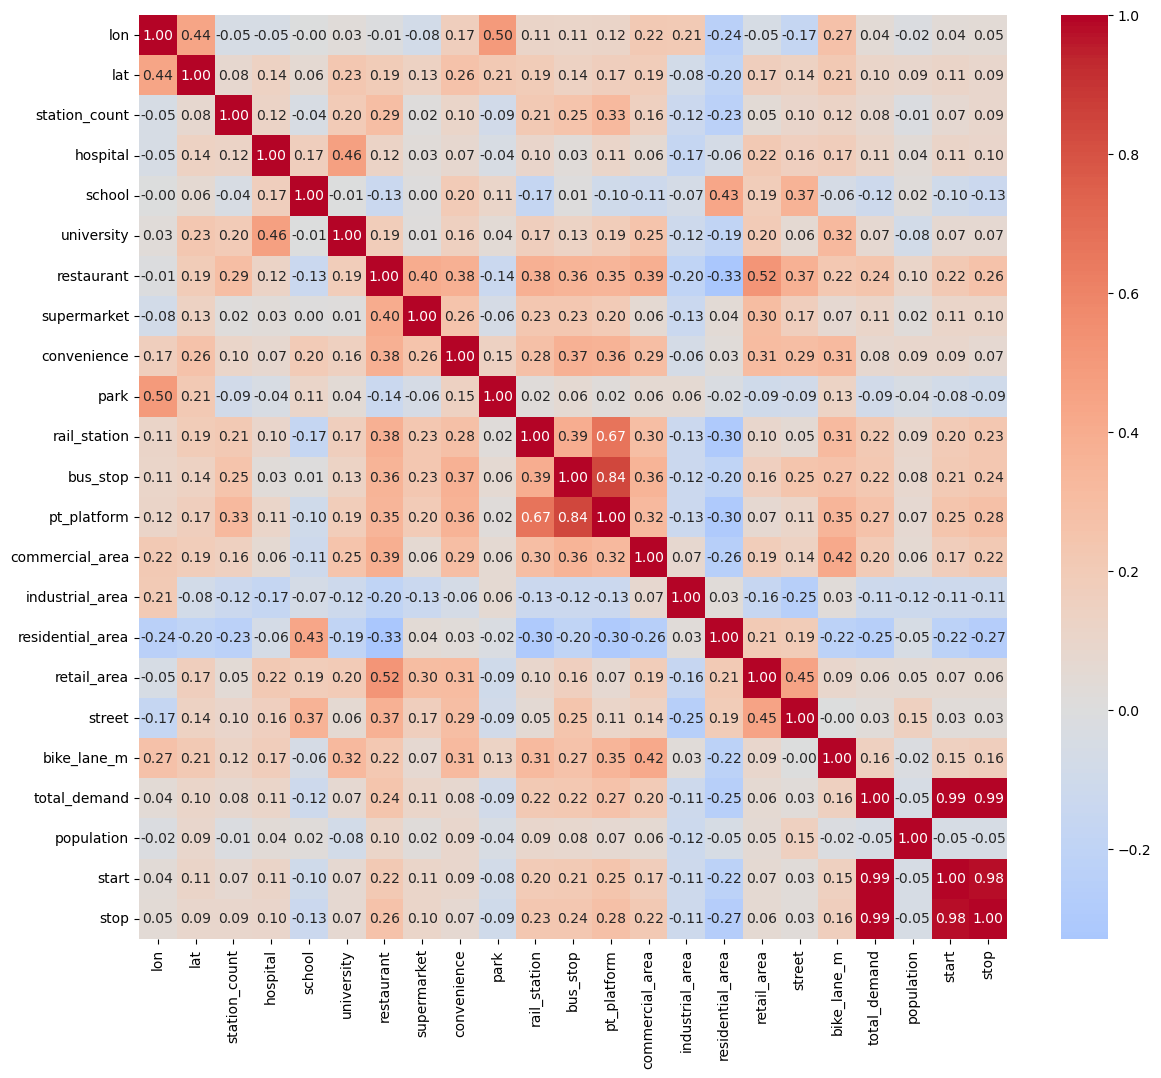

In [21]:
# We want to reduce the dimensionality of the data
df_predictor = df.drop(columns=['name', 'geometry', 'lon','lat','h3_index'])

corr = df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.show()


In [24]:
df[['total_demand', 'commercial_area', 'bike_lane_m', 'population']].describe()


,total_demand,commercial_area,bike_lane_m,population
count,793.000000,793.000000,793.000000,793.000000
mean,22427.475410,6.991173,1361.697028,1671.413619
std,13575.085608,9.112439,1043.741093,799.092677
min,128.000000,0.000000,0.000000,0.000000
25%,13712.000000,1.000000,577.418689,1450.000000
50%,19780.000000,3.000000,1150.984726,1742.000000
75%,27086.000000,8.000000,1922.082456,2169.000000
max,127581.000000,46.000000,6082.086820,3952.000000


In [8]:
# Merge POI variables into a single variable
df['POI'] = df[['hospital', 'school', 'university', 'restaurant', 
                'supermarket', 'convenience', 'park', 'pt_platform']].sum(axis=1)

In [9]:
predictor_columns = [
    'station_count', 'POI', 'commercial_area', 'industrial_area', 
    'residential_area', 'retail_area', 'street', 'bike_lane_m', 'population'
]

X = df[predictor_columns]
y = df['total_demand']

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

KeyError: "['street', 'bike_lane_m'] not in index"

In [ ]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance on Test Set:")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Model Performance on Test Set:
R² Score: 0.096
Mean Absolute Error (MAE): 7885.09
Root Mean Squared Error (RMSE): 10442.85


Feature importances:
POI                 0.192029
street              0.165214
bike_lane_m         0.154562
residential_area    0.154407
retail_area         0.102000
population          0.089700
commercial_area     0.079499
industrial_area     0.040840
station_count       0.021750
dtype: float64


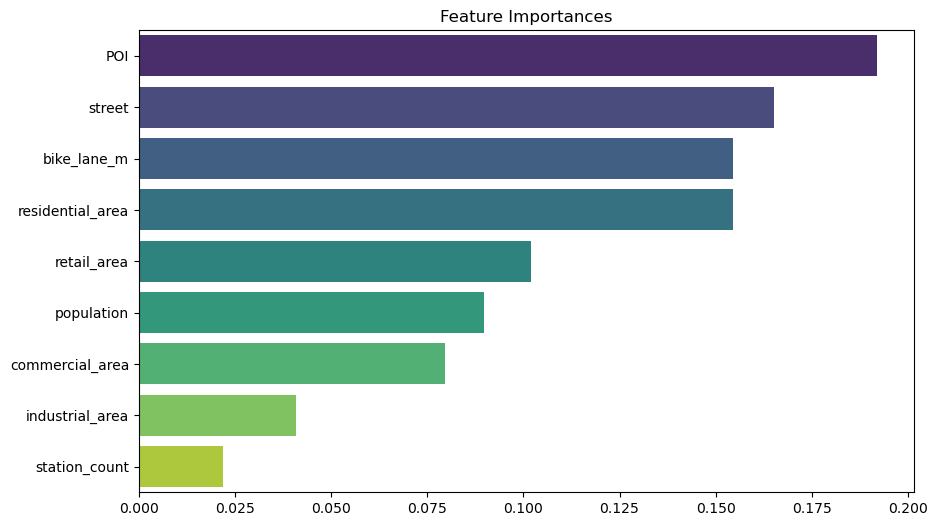

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title('Feature Importances')

print("Feature importances:")
print(importances)
plt.show()